# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

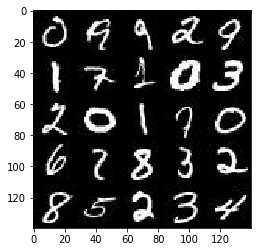

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

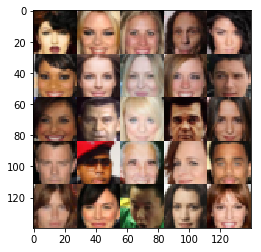

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img_dim = (image_width, image_height, image_channels)
    input_real = tf.placeholder(tf.float32, shape=(None, *img_dim), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    lr = tf.placeholder(tf.float32, name="learning_rate")

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    def get_loss(logits, zero_like=True, smooth=0.9):
        if zero_like:
            labels = tf.zeros_like(logits) * smooth
        else:
            labels = tf.ones_like(logits) * smooth
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels)  
        return tf.reduce_mean(cross_entropy)

    d_loss_real = get_loss(d_logits_real, zero_like=False)
    d_loss_fake = get_loss(d_logits_fake, zero_like=True)
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = get_loss(d_logits_fake, zero_like=False)

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, 
          get_batches, data_shape, data_image_mode, save_as=None, show_face_n=36):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    out_channel_dim = data_shape[3]
    losses = []
    steps, print_every, show_every = 0, 20, 200
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim) 
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    # Only save generator variables
    g_vars = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
    saver = tf.train.Saver(var_list=g_vars)
  
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, lr: learning_rate})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, show_face_n, input_z, out_channel_dim, data_image_mode)
        
        if save_as is not None:
            saver.save(sess, 'checkpoints/{0}.ckpt'.format(save_as))
    
    try:
        # Plot Loss
        fig, ax = plt.subplots()
        losses = np.array(losses)
        plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
        plt.plot(losses.T[1], label='Generator', alpha=0.5)
        plt.title("Training Losses")
        plt.legend()
    except Exception as e:
        pass         

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.1283... Generator Loss: 0.3666
Epoch 1/2... Discriminator Loss: 2.1268... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.9771... Generator Loss: 0.4088
Epoch 1/2... Discriminator Loss: 1.6980... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 0.5507


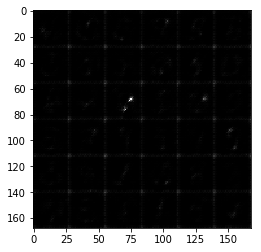

Epoch 1/2... Discriminator Loss: 1.6398... Generator Loss: 0.5568
Epoch 1/2... Discriminator Loss: 1.5803... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.6459... Generator Loss: 0.5392
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.5073... Generator Loss: 0.5405


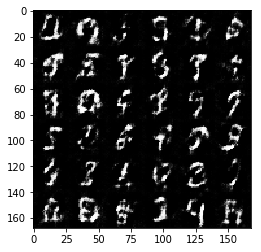

Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.8569
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.7681
Epoch 1/2... Discriminator Loss: 1.4634... Generator Loss: 0.6341
Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.6195
Epoch 1/2... Discriminator Loss: 1.5486... Generator Loss: 0.5332


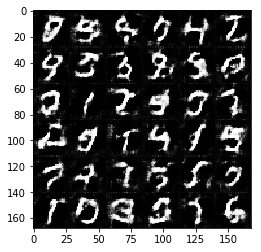

Epoch 1/2... Discriminator Loss: 1.4187... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.6992... Generator Loss: 0.4481
Epoch 1/2... Discriminator Loss: 1.4758... Generator Loss: 0.6459
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.9451
Epoch 1/2... Discriminator Loss: 1.4705... Generator Loss: 0.6937


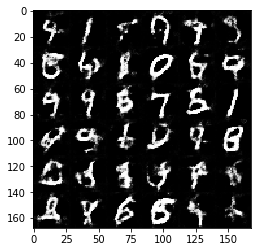

Epoch 1/2... Discriminator Loss: 1.4709... Generator Loss: 0.8646
Epoch 1/2... Discriminator Loss: 1.5393... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.7644
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.6396


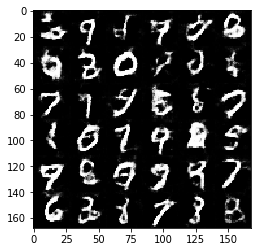

Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.9780
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.5310
Epoch 1/2... Discriminator Loss: 1.4010... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.7246


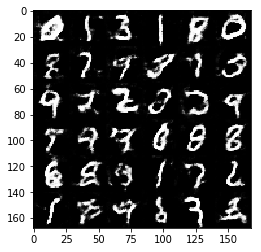

Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.5212
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.7467
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.7707


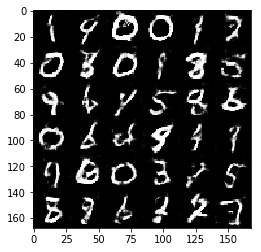

Epoch 1/2... Discriminator Loss: 1.4353... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 1.5908... Generator Loss: 1.0459
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8191


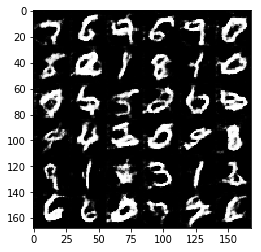

Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 1.0766
Epoch 1/2... Discriminator Loss: 1.6696... Generator Loss: 0.4654
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.4557
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.4971


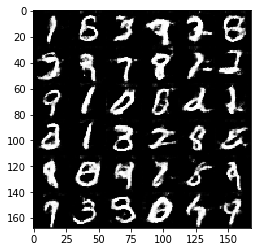

Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 1.3622... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.6710
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.5398... Generator Loss: 0.5218


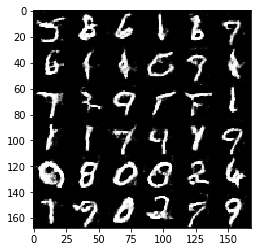

Epoch 2/2... Discriminator Loss: 1.6109... Generator Loss: 0.4738
Epoch 2/2... Discriminator Loss: 1.6811... Generator Loss: 0.4375
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.7527
Epoch 2/2... Discriminator Loss: 1.3941... Generator Loss: 0.6965
Epoch 2/2... Discriminator Loss: 1.4244... Generator Loss: 0.5755


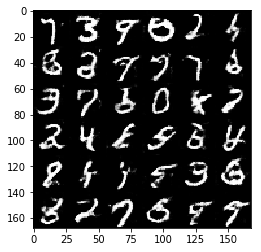

Epoch 2/2... Discriminator Loss: 1.3676... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.5496... Generator Loss: 0.5336
Epoch 2/2... Discriminator Loss: 1.5716... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 1.3056... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.4900... Generator Loss: 0.8652


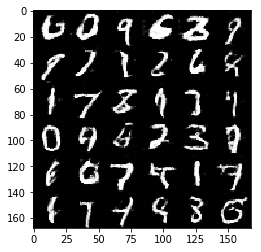

Epoch 2/2... Discriminator Loss: 1.2440... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.3799... Generator Loss: 0.9880
Epoch 2/2... Discriminator Loss: 1.3509... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.3104... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 1.1045


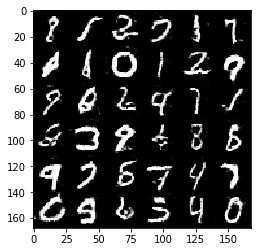

Epoch 2/2... Discriminator Loss: 1.4188... Generator Loss: 0.5855
Epoch 2/2... Discriminator Loss: 1.3247... Generator Loss: 0.6443
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.8080
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 1.5085... Generator Loss: 0.5686


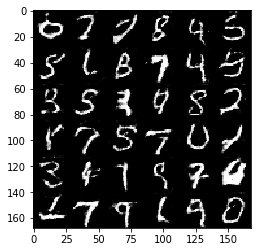

Epoch 2/2... Discriminator Loss: 1.4386... Generator Loss: 0.6396
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.6151
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 1.2701... Generator Loss: 0.8611


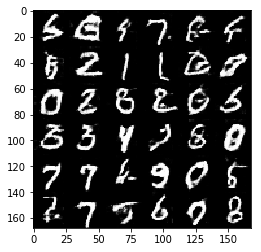

Epoch 2/2... Discriminator Loss: 1.6543... Generator Loss: 0.4485
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7423
Epoch 2/2... Discriminator Loss: 1.4529... Generator Loss: 0.8632
Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.5103
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7111


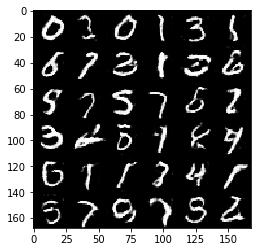

Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.6633
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.5405
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.7873
Epoch 2/2... Discriminator Loss: 1.3025... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.7369


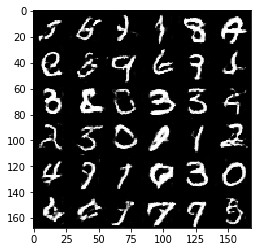

Epoch 2/2... Discriminator Loss: 1.4789... Generator Loss: 0.5232
Epoch 2/2... Discriminator Loss: 1.3817... Generator Loss: 0.6770
Epoch 2/2... Discriminator Loss: 1.5087... Generator Loss: 0.5079
Epoch 2/2... Discriminator Loss: 1.4422... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.5756


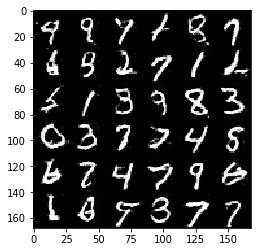

Epoch 2/2... Discriminator Loss: 1.4938... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 1.2740... Generator Loss: 0.6391


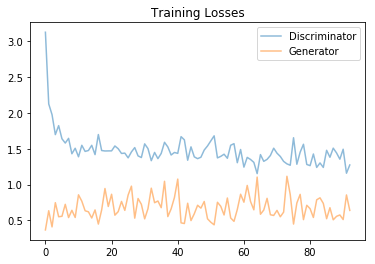

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, save_as='mnist_generator')

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 1.3955
Epoch 1/1... Discriminator Loss: 4.1477... Generator Loss: 4.8484
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.6455... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 1.1499
Epoch 1/1... Discriminator Loss: 1.7725... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.5632... Generator Loss: 0.8585


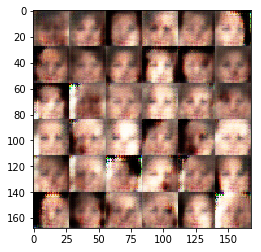

Epoch 1/1... Discriminator Loss: 1.5832... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.9172
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6889


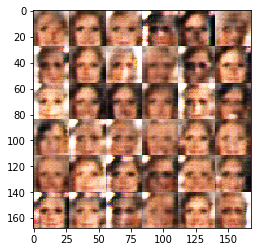

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7736


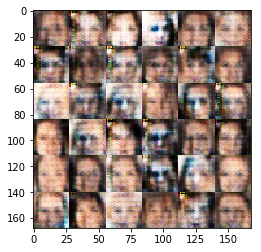

Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7492
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.8383


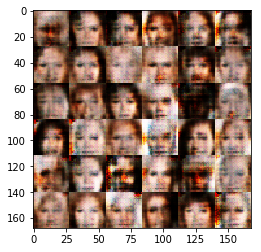

Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.4772... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.8251


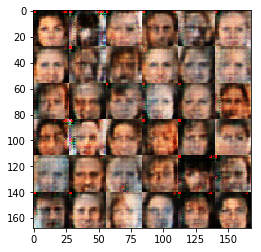

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.8790
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.8445


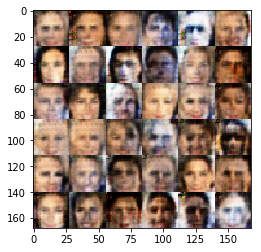

Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7251


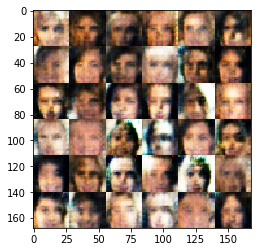

Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.7612


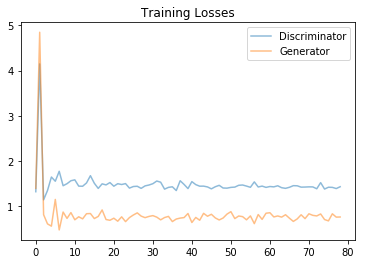

In [12]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, save_as='celeba_generator')

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.